In [1]:
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
import math

from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
# from common.utils import load_data, mape
from IPython.display import Image
warnings.filterwarnings("ignore") # specify to ignore warning messages


In [2]:
energy = pd.read_csv('./energy.csv', index_col=0)
energy.drop(['temp'], axis=1, inplace=True)
energy.head(10)

,load
timestamp,
2012-01-01 00:00:00,2698.0
2012-01-01 01:00:00,2558.0
2012-01-01 02:00:00,2444.0
2012-01-01 03:00:00,2402.0
2012-01-01 04:00:00,2403.0
2012-01-01 05:00:00,2453.0
2012-01-01 06:00:00,2560.0
2012-01-01 07:00:00,2719.0
2012-01-01 08:00:00,2916.0


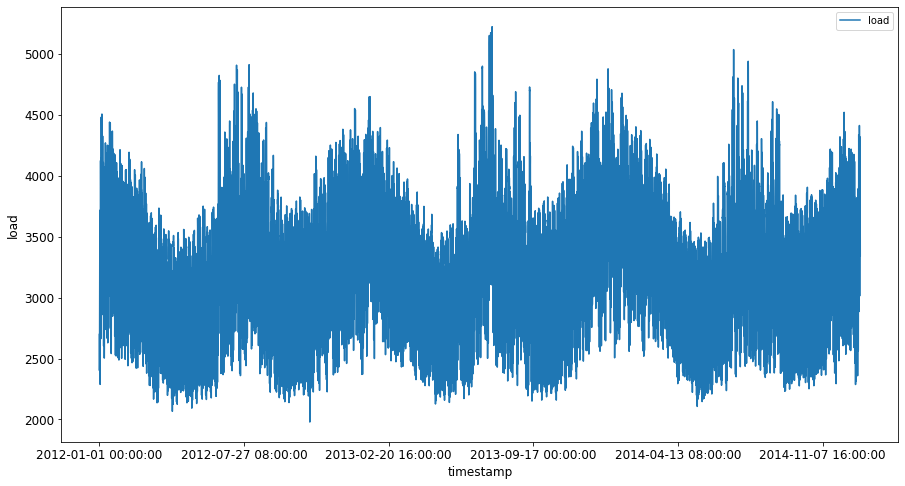

In [3]:
energy.plot(y='load', subplots=True, figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

In [4]:
train_start_dt = '2014-11-01 00:00:00'
test_start_dt = '2014-12-30 00:00:00'

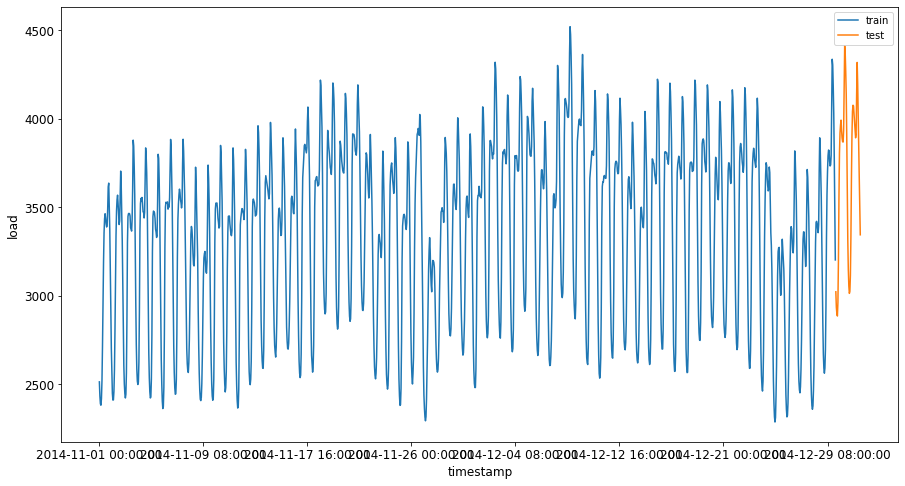

In [5]:
energy[(energy.index < test_start_dt) & (energy.index >= train_start_dt)][['load']].rename(columns={'load':'train'}) \
    .join(energy[test_start_dt:][['load']].rename(columns={'load':'test'}), how='outer') \
    .plot(y=['train', 'test'], figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

In [6]:
train = energy.copy()[(energy.index >= train_start_dt) & (energy.index < test_start_dt)][['load']]
test = energy.copy()[energy.index >= test_start_dt][['load']]

print('Training data shape: ', train.shape)
print('Test data shape: ', test.shape)

Training data shape:  (1416, 1)
Test data shape:  (48, 1)


In [7]:
scaler = MinMaxScaler()
train['load'] = scaler.fit_transform(train)
train.head(10)

,load
timestamp,
2014-11-01 00:00:00,0.101611
2014-11-01 01:00:00,0.065801
2014-11-01 02:00:00,0.046106
2014-11-01 03:00:00,0.042525
2014-11-01 04:00:00,0.059087
2014-11-01 05:00:00,0.104297
2014-11-01 06:00:00,0.191137
2014-11-01 07:00:00,0.305730
2014-11-01 08:00:00,0.403760


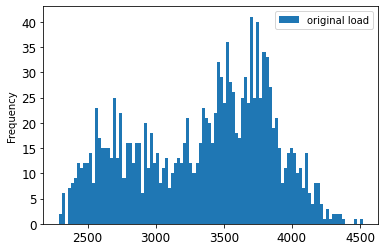

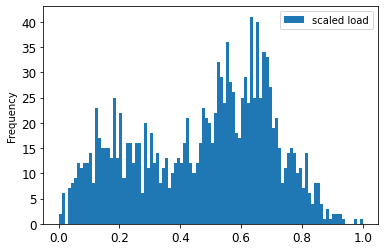

In [8]:
energy[(energy.index >= train_start_dt) & (energy.index < test_start_dt)][['load']].rename(columns={'load':'original load'}).plot.hist(bins=100, fontsize=12)
train.rename(columns={'load':'scaled load'}).plot.hist(bins=100, fontsize=12)
plt.show()

In [9]:
test['load'] = scaler.transform(test)
test.head()

,load
timestamp,
2014-12-30 00:00:00,0.329454
2014-12-30 01:00:00,0.290063
2014-12-30 02:00:00,0.273948
2014-12-30 03:00:00,0.268129
2014-12-30 04:00:00,0.302596


In [10]:
# Specify the number of steps to forecast ahead
HORIZON = 3
print('Forecasting horizon:', HORIZON, 'hours')

Forecasting horizon: 3 hours


In [11]:
order = (4, 1, 0)
seasonal_order = (1, 1, 0, 24)

model = SARIMAX(endog=train, order=order, seasonal_order=seasonal_order)
results = model.fit()

print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                               load   No. Observations:                 1416
Model:             SARIMAX(4, 1, 0)x(1, 1, 0, 24)   Log Likelihood                3477.235
Date:                            Thu, 13 Jan 2022   AIC                          -6942.469
Time:                                    14:22:19   BIC                          -6911.042
Sample:                                11-01-2014   HQIC                         -6930.717
                                     - 12-29-2014                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8387      0.016     52.215      0.000       0.807       0.870
ar.L2         -0.5201      0.034   

In [12]:
test_shifted = test.copy()
for t in range(1, HORIZON+1):
    test_shifted['load+'+str(t)] = test_shifted['load'].shift(-t, freq='H')
test_shifted = test_shifted.dropna(how='any')

In [13]:
%%time
training_window = 720 # dedicate 30 days (720 hours) for training

train_ts = train['load']
test_ts = test_shifted

history = [x for x in train_ts]
history = history[(-training_window):]

predictions = list()

order = (2, 1, 0)
seasonal_order = (1, 1, 0, 24)

for t in range(test_ts.shape[0]):
    model = SARIMAX(endog=history, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit()
    yhat = model_fit.forecast(steps = HORIZON)
    predictions.append(yhat)
    obs = list(test_ts.iloc[t])
    # move the training window
    history.append(obs[0])
    history.pop(0)
    print(test_ts.index[t])
    print(t+1, ': predicted =', yhat, 'expected =', obs)

2014-12-30 00:00:00
1 : predicted = [0.32318476 0.28779087 0.27842679] expected = [0.32945389435989236]
2014-12-30 01:00:00
2 : predicted = [0.29931606 0.29139642 0.30233282] expected = [0.2900626678603402]
2014-12-30 02:00:00
3 : predicted = [0.27443737 0.28325325 0.32258596] expected = [0.2739480752014323]
2014-12-30 03:00:00
4 : predicted = [0.28232674 0.32146967 0.41599167] expected = [0.26812891674127126]
2014-12-30 04:00:00
5 : predicted = [0.29521607 0.38636617 0.53903591] expected = [0.3025962399283795]
2014-12-30 05:00:00
6 : predicted = [0.40006717 0.55468739 0.664947  ] expected = [0.40823634735899716]
2014-12-30 06:00:00
7 : predicted = [0.56890401 0.68078435 0.75014607] expected = [0.5689346463742166]
2014-12-30 07:00:00
8 : predicted = [0.6808642  0.75029884 0.79935049] expected = [0.6799462846911368]
2014-12-30 08:00:00
9 : predicted = [0.7485082  0.7972184  0.81745655] expected = [0.7309758281110115]
2014-12-30 09:00:00
10 : predicted = [0.76513819 0.78114637 0.78332322